<a href="https://colab.research.google.com/github/WinningHabits/lottery/blob/main/08_Probabilistic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx'
data = pd.read_excel(url)

In [4]:
prior_a = 1
prior_b = 1


In [6]:
# Count occurrences of the number 7 across all relevant columns
observed_successes = sum((data['Draw number 1'] == 7) |
                         (data['Draw number 2'] == 7) |
                         (data['Draw number 3'] == 7) |
                         (data['Draw number 4'] == 7) |
                         (data['Draw number 5'] == 7) |
                         (data['Draw number 6'] == 7))

# Calculate the total number of draws and subtract the successes to get failures
total_draws = 6 * len(data)
observed_failures = total_draws - observed_successes


In [7]:
from scipy.stats import beta

# Assuming you have prior_a and prior_b as prior parameters for Beta distribution
# and observed_successes and observed_failures from new data:
posterior_a = prior_a + observed_successes
posterior_b = prior_b + observed_failures

posterior_distribution = beta(posterior_a, posterior_b)


In [9]:
# Flatten the dataset to get a sequence of drawn numbers
sequence = data[['Draw number 1', 'Draw number 2', 'Draw number 3', 'Draw number 4', 'Draw number 5', 'Draw number 6']].values.flatten()

# Compute state transitions
transitions = {}
for i in range(len(sequence)-1):
    current_num, next_num = sequence[i], sequence[i+1]
    if current_num not in transitions:
        transitions[current_num] = {}
    if next_num not in transitions[current_num]:
        transitions[current_num][next_num] = 0
    transitions[current_num][next_num] += 1

# The 'transitions' dictionary now contains the number of times each number is followed by another


In [12]:
# Assuming the data is loaded in a DataFrame called data

# Initialize the matrix with zeros
transition_matrix = np.zeros((49, 49))

# Extract the column of interest (in this case, the first drawn number)
numbers = data['Draw number 1'].values

# Populate the transition matrix
for i in range(len(numbers) - 1):
    start_num = numbers[i] - 1  # Subtracting 1 to make it 0-indexed
    end_num = numbers[i+1] - 1
    transition_matrix[start_num, end_num] += 1

# Normalize the matrix to get probabilities
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums!=0)  # This avoids division by zero


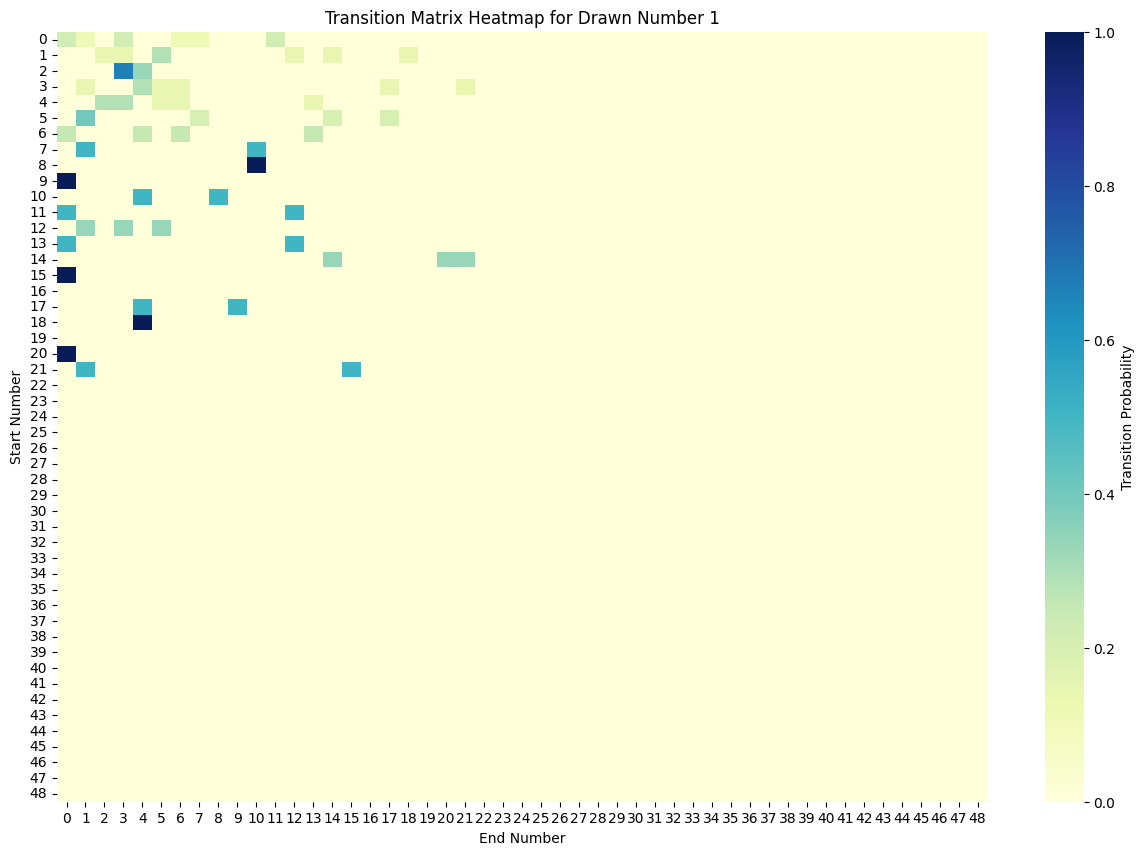

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already constructed the transition_matrix as shown previously

plt.figure(figsize=(15, 10))
sns.heatmap(transition_matrix, cmap="YlGnBu", cbar_kws={'label': 'Transition Probability'})
plt.title("Transition Matrix Heatmap for Drawn Number 1")
plt.xlabel("End Number")
plt.ylabel("Start Number")
plt.show()


In [16]:
!pip install pgmpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.5 MB/s eta 0:00:00


In [18]:
model = BayesianModel([('Drawn Number 1', 'Drawn Number 2'),
                       ('Drawn Number 2', 'Drawn Number 3'),
                       ('Drawn Number 3', 'Drawn Number 4'),
                       # ... continue specifying the relationships
                      ])
